# Modeling

In [1]:
from function import *

In [2]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.tail()

,Team,Possession,SOT,Shots,Touches,Passes,Tackles,Clearances,Corners,Offsides,Goal,Year,Home,Result
3795,Stoke City,39.0,3,14,510,319,16,29,10,2,1,2016,0,1
3796,Swansea City,65.3,2,12,795,589,17,17,7,1,2,2016,1,1
3797,West Bromwich Albion,34.7,5,16,500,316,18,24,4,0,1,2016,0,0
3798,Watford,32.9,3,6,440,297,20,6,4,0,0,2016,1,0
3799,Manchester City,67.1,9,15,789,620,19,13,5,2,5,2016,0,1


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_train = train.drop(['Team', 'Result', 'Possession', 'Touches', 'Year'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_train.values, i) for i in range(vif_train.shape[1])]
vif["features"] = vif_train.columns
vif

,VIF Factor,features
0,10.891017,SOT
1,18.119610,Shots
2,13.584108,Passes
3,8.768193,Tackles
4,5.604560,Clearances
5,6.229887,Corners
6,2.627631,Offsides
7,3.461194,Goal
8,2.216191,Home


### 1. Select columns & Encoding

In [5]:
# Select columns
category = ['Home']
continuous = ['Shots', 'Tackles', 'Clearances','SOT', 'Corners', 'Offsides', 'Goal', ]

In [6]:
# make train/test data

train_cols, test_cols = [], []

# category
for cat in category:
    train_tok, test_tok = category_to_ohe(train[cat],test[cat])
    train_cols.append(train_tok)
    test_cols.append(test_tok)    

# continuous
for con in continuous:
    train_cols.append(train[con].values.reshape(len(train),1))
    test_cols.append(test[con].values.reshape(len(test),1))
 

In [7]:
# stack train/test data
X_train = np.hstack(tuple(each for each in train_cols))
X_test = np.hstack(tuple(each for each in test_cols))
y_train = train['Result']

In [8]:
X_train.shape

(3800, 8)

In [9]:
X_test

array([[ 1, 27, 23, ...,  9,  5,  4],
       [ 0,  6, 17, ...,  4,  3,  3],
       [ 1,  6, 10, ...,  3,  6,  0],
       ...,
       [ 0, 16, 22, ...,  4,  4,  4],
       [ 1, 15, 11, ...,  6,  4,  3],
       [ 0, 14, 10, ...,  6,  1,  1]])

In [10]:
y_train.tail()

3795    1
3796    1
3797    0
3798    0
3799    1
Name: Result, dtype: int64

---

### 2. Modeling

 - 조건부 확률 모형 : 각 클래스가 정답일 조건부 확률을 계산

    - 조건부 확률기반 생성모형 : 베이즈 정리를 사용

        - LDA (linear discriminant analysis)
        - QDA (Quadratic Discriminanat Analysis)
        - 나이브 베이지안 (Naive Bayes)
    
    - 조건부 확률기반 판별모형 :  직접 조건부 확률 함수를 추정
    
        - 로지스틱 회귀 (Logistic Regression)
        - 의사결정나무 (Descision Tree)
        - KNN (K Nearest Neighbor)
        
        
- 판별함수 모형 : 경계면을 찾아서 데이터가 어느 위치에 있는지 계산

    - 퍼셉트론 (Perceptron)
    - 서포트 벡터 머신 (Support Vector Machine)
    - 신경망 (Neural Network)  
    
    
- 모형결합 (Ensemble) : 복수의 예측모형을 결합하여 더 나은 성능을 예측하려는 시도

    - 취합 방법론 : 사용할 모형의 집합이 이미 결정되어 있음
        
        - 다수결 (Majority voting)
        - 배깅 (Bagging)
        - 랜덤 포레스트 (Random Forest)
        
    - 부스팅 방법론 : 사용할 모형을 점진적으로 늘림
    
        - 에이다 부스트 (AdaBoost)
        - 그레디언트 부스트 (Gradient Boost)

---

#### 2.1 조건부 확률모형

##### 2.1.1 조건부 확률기반 생성 모형

In [122]:
# LDA (linear discriminant analysis)
model = LinearDiscriminantAnalysis(n_components=3, solver="svd", 
        store_covariance=True).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[259  20   2]
 [ 51 206  24]
 [133  44  21]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.58      0.92      0.72       281
        Win       0.76      0.73      0.75       281
       Draw       0.45      0.11      0.17       198

avg / total       0.61      0.64      0.59       760



In [11]:
# QDA (Quadratic Discriminanat Analysis)
model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[246  19  16]
 [ 42 212  27]
 [119  43  36]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.60      0.88      0.72       281
        Win       0.77      0.75      0.76       281
       Draw       0.46      0.18      0.26       198

avg / total       0.63      0.65      0.61       760



In [12]:
# Naive bayesian - Multinomial
model = MultinomialNB().fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[205  29  47]
 [ 53 176  52]
 [ 93  52  53]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.58      0.73      0.65       281
        Win       0.68      0.63      0.65       281
       Draw       0.35      0.27      0.30       198

avg / total       0.56      0.57      0.56       760



---

##### 2.1.2 조건부 확률기반 판별모형

In [13]:
# Logistic Regression : 사용 X (종속변수가 이항분포를 따라야함)

In [14]:
# Descision Tree
model = DecisionTreeClassifier(criterion='entropy', 
        max_depth=7, min_samples_leaf=5).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[227  24  30]
 [ 33 214  34]
 [114  50  34]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.61      0.81      0.69       281
        Win       0.74      0.76      0.75       281
       Draw       0.35      0.17      0.23       198

avg / total       0.59      0.62      0.59       760



In [15]:
# KNN (K Nearest Neighbor)

---

#### 2.2 모형결합 (Ensemble)

##### 2.2.1 취합 방법론

In [31]:
# 다수결 (Majority voting)

# 취합할 모델 생성
model1 = LinearDiscriminantAnalysis(n_components=3, solver="svd", store_covariance=True)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
model4 = MultinomialNB()

# ensemble 생성
ensemble = VotingClassifier(estimators=[('lda', model1), ('qda', model2), ('gnb', model3), ('mul', model4)], 
                            voting='soft', weights=[2, 4, 1, 5])

predict_proba = [c.fit(X_train, y_train).predict_proba(X_test) for c in (model1, model2, model3, model4, ensemble)]

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[4][i])) # ensemble index

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[246  20  15]
 [ 44 206  31]
 [119  44  35]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.60      0.88      0.71       281
        Win       0.76      0.73      0.75       281
       Draw       0.43      0.18      0.25       198

avg / total       0.62      0.64      0.61       760



In [17]:
# 배깅 (Bagging)
model1 = DecisionTreeClassifier().fit(X_train, y_train)
model2 = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0).fit(X_train, y_train)
predict_proba = model2.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[207  39  35]
 [ 43 212  26]
 [113  54  31]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.57      0.74      0.64       281
        Win       0.70      0.75      0.72       281
       Draw       0.34      0.16      0.21       198

avg / total       0.56      0.59      0.56       760



In [34]:
# 랜덤포레스트 (RandomForest)
clf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_split = 10, criterion = 'entropy')
model = clf.fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[247  28   6]
 [ 37 234  10]
 [127  58  13]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.60      0.88      0.71       281
        Win       0.73      0.83      0.78       281
       Draw       0.45      0.07      0.11       198

avg / total       0.61      0.65      0.58       760



---

##### 2.2.2 부스팅 방법론

In [35]:
# 에이다 부스트 (Ada Boost)
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=0), 
                               algorithm="SAMME", n_estimators=300).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[200  29  52]
 [ 26 208  47]
 [ 85  59  54]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.64      0.71      0.68       281
        Win       0.70      0.74      0.72       281
       Draw       0.35      0.27      0.31       198

avg / total       0.59      0.61      0.60       760



In [67]:
# 그레디언트 부스트 (Gradient Boost)
model = GradientBoostingClassifier(n_estimators=1000, max_depth=5, random_state=0).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[219  20  42]
 [ 37 199  45]
 [100  53  45]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.62      0.78      0.69       281
        Win       0.73      0.71      0.72       281
       Draw       0.34      0.23      0.27       198

avg / total       0.59      0.61      0.59       760



In [65]:
# XG boost
model = xgboost.XGBClassifier(n_estimators=500, max_depth=2).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[246  21  14]
 [ 37 225  19]
 [110  55  33]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.63      0.88      0.73       281
        Win       0.75      0.80      0.77       281
       Draw       0.50      0.17      0.25       198

avg / total       0.64      0.66      0.62       760



---

#### 2.3 판별함수 모형

In [21]:
# 퍼셉트론 (Perceptron) - perceptron
model = Perceptron(max_iter=500, eta0=0.1, random_state=1).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
# 퍼셉트론 (Perceptron) - SGD
model = SGDClassifier(loss="hinge", max_iter=3, random_state=1).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
# 서포트 벡터 머신 (Support Vector Machine) - linear
model = SVC(kernel='linear').fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
# 서포트 벡터 머신 (Support Vector Machine) - 다항 커널 (Polynomial Kernel)
model = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
# 서포트 벡터 머신 (Support Vector Machine) - RBF(Radial Basis Function)
model = SVC(kernel="rbf").fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# 서포트 벡터 머신 (Support Vector Machine) - 시그모이드 커널 (Sigmoid Kernel)
model = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_train, y_train)
predict_proba = model.predict(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[281   0   0]
 [281   0   0]
 [198   0   0]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.37      1.00      0.54       281
        Win       0.00      0.00      0.00       281
       Draw       0.00      0.00      0.00       198

avg / total       0.14      0.37      0.20       760



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
# 신경망 (Neural Network)

---

In [43]:
# XG boost
model = xgboost.XGBClassifier(n_estimators=500, max_depth=2).fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)

# comparison
y_true = test['Result']
y_pred = []

for i in range(760) :
    y_pred.append(np.argmax(predict_proba[i]))

target_names = ['Lose', 'Win', 'Draw']
print('Confusion Matrix : \n\n',confusion_matrix(y_true, y_pred))
print('\n\n Classification Report : \n\n', classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix : 

 [[246  21  14]
 [ 37 225  19]
 [110  55  33]]


 Classification Report : 

              precision    recall  f1-score   support

       Lose       0.63      0.88      0.73       281
        Win       0.75      0.80      0.77       281
       Draw       0.50      0.17      0.25       198

avg / total       0.64      0.66      0.62       760



In [45]:
# make binarize
y0 = []
for i in range(len(y_true)):
    if y_true[i] == 0 :
        y0.append(1) # y가 0이면 1
    else:
        y0.append(0) # y가 0이 아니면 0
    
y1 = []
for i in range(len(y_true)):
    if y_true[i] == 1 :
        y1.append(1) # y가 1이면 1
    else:
        y1.append(0) # y가 1이 아니면 0
        
y2 = []
for i in range(len(y_true)):
    if y_true[i] == 2 :
        y2.append(1) # y가 2이면 1
    else:
        y2.append(0) # y가 2가 아니면 0   

In [46]:
# make model
fpr1, tpr1, thresholds1 = roc_curve(y0, model.predict_proba(X_test)[:, 0])
fpr2, tpr2, thresholds2 = roc_curve(y1, model.predict_proba(X_test)[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y2, model.predict_proba(X_test)[:, 2])

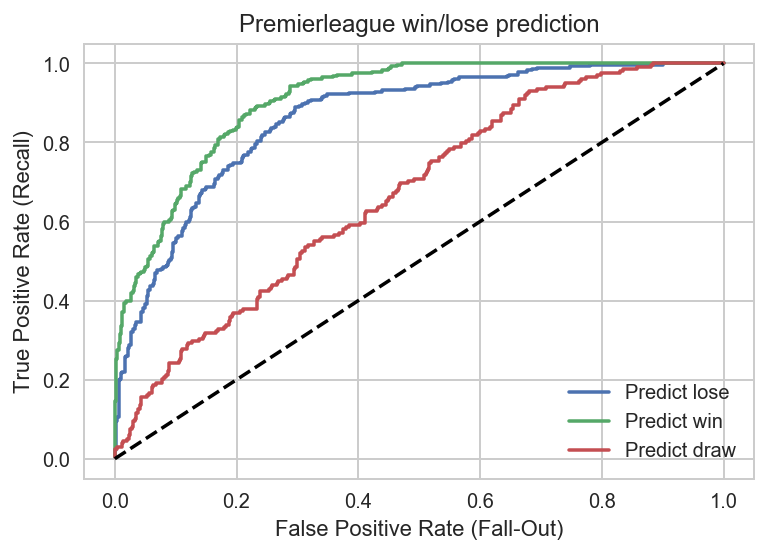

In [51]:
# ROC curve
plt.plot(fpr1, tpr1, label= 'Predict lose')
plt.plot(fpr2, tpr2, label= 'Predict win')
plt.plot(fpr3, tpr3, label= 'Predict draw')
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Premierleague win/lose prediction')
plt.show()

In [48]:
# AUC score
auc(fpr1, tpr1), auc(fpr2, tpr2), auc(fpr3, tpr3)

(0.8619603414587033, 0.908060238188991, 0.667996692907725)